# Gradient-free `CRP` parameter optimization

In [6]:
import pennylane as qml
from pennylane import numpy as np
from numpy.typing import NDArray

import math

from scipy.optimize import minimize

from matplotlib import pyplot as plt

## 1. Set up demo circuit

In [7]:
dev = qml.device("default.qubit", wires=4, shots=None)

num_layers = 5
num_qubits = 4

@qml.qnode(dev)
def an_interesting_circuit(params: NDArray[np.float_]):
    for layer in range(num_layers):
        for qubit in range(num_qubits):
            qml.RX(params[layer, qubit, 0], wires=qubit)
            qml.RZ(params[layer, qubit, 1], wires=qubit)
        for qubit in range(num_qubits - 2, -1, -1): # incl. start, excl. stop, step
            qml.CRZ(params[layer, qubit, 2], (qubit + 1, qubit))
    return qml.expval(qml.PauliZ(1))

print(qml.draw(an_interesting_circuit)(np.random.random((num_layers, num_qubits, 3))))

0: ──RX(0.71)──RZ(0.29)─────────────────────╭RZ(0.75)──RX(0.57)──RZ(0.70)───────────╭RZ(0.41)
1: ──RX(0.94)──RZ(0.99)───────────╭RZ(0.87)─╰●─────────RX(0.31)──RZ(0.16)─╭RZ(0.39)─╰●───────
2: ──RX(0.63)──RZ(0.55)─╭RZ(0.92)─╰●─────────RX(0.05)──RZ(0.21)─╭RZ(0.73)─╰●─────────RX(0.85)
3: ──RX(0.75)──RZ(0.04)─╰●─────────RX(0.86)──RZ(0.68)───────────╰●─────────RX(0.65)──RZ(0.65)

───RX(0.90)──RZ(0.73)───────────╭RZ(0.54)──RX(0.11)──RZ(0.83)───────────╭RZ(0.67)──RX(0.68)
───RX(0.62)──RZ(0.48)─╭RZ(0.66)─╰●─────────RX(0.76)──RZ(0.53)─╭RZ(0.71)─╰●─────────RX(0.98)
───RZ(0.64)─╭RZ(0.14)─╰●─────────RX(0.61)──RZ(0.85)─╭RZ(0.30)─╰●─────────RX(0.25)──RZ(0.51)
────────────╰●─────────RX(0.32)──RZ(0.39)───────────╰●─────────RX(0.16)──RZ(0.31)──────────

───RZ(0.70)───────────╭RZ(0.44)─┤     
───RZ(0.08)─╭RZ(0.33)─╰●────────┤  <Z>
──╭RZ(0.14)─╰●──────────────────┤     
──╰●────────────────────────────┤     


## 2. Optimization loop

In [8]:
def create_univariate(circuit, params: NDArray[np.int_], param_index):
    def univariate(param_value):
        updated_params = params.copy()
        updated_params[param_index] = param_value
        return circuit(updated_params)
    
    return univariate

In [9]:
from reconstruction import reconstruct
from minimization import minimize_reconstruction

# in each iteration, reconstruct and optimize the univariate cost functions independently
def crotosolve_iteration(circuit, params, updates_dataset, debug = False):
    final_value = 42

    iterator = np.nditer(params, flags=['multi_index'])
    for old_param_value in iterator:
        param_index = iterator.multi_index
        if debug: print(f"Optimizing parameter {param_index}...")
        univariate = create_univariate(circuit, params, param_index)
        reconstruction, constants = reconstruct(univariate)
        new_param_value, new_fun_value = minimize_reconstruction(reconstruction, constants)
        if debug: print(f"Parameter update for {param_index} from {old_param_value} to {new_param_value} ({new_fun_value})")
        params[param_index] = new_param_value
        final_value = new_fun_value
        updates_dataset.append(new_fun_value)
    
    return final_value

In [10]:
def crotosolve(circuit, initial_params, debug = False):
    iterations_dataset = []
    updates_dataset = []

    params = initial_params.copy()
    for iteration in range(5):
        if debug: print(f" ===== ITERATION NO {iteration} =====")
        new_fun_value = crotosolve_iteration(circuit, params, updates_dataset, debug=debug)
        iterations_dataset.append(new_fun_value)
    
    return params, iterations_dataset, updates_dataset

rng = np.random.default_rng()
params = rng.random((5, 4, 3))

final_params, iterations_dataset, updates_dataset = crotosolve(an_interesting_circuit, params, debug=True)

 ===== ITERATION NO 0 =====
Optimizing parameter (0, 0, 0)...
Parameter update for (0, 0, 0) from 0.6207663518696224 to 10.901689960083022 (-0.24710244760930455)
Optimizing parameter (0, 0, 1)...


Parameter update for (0, 0, 1) from 0.807780923185753 to 5.911885739871089 (-0.5428576104444485)
Optimizing parameter (0, 0, 2)...
Parameter update for (0, 0, 2) from 0.42753721532321554 to 8.497469334027066 (-0.5859851740923451)
Optimizing parameter (0, 1, 0)...
Parameter update for (0, 1, 0) from 0.3117940481142063 to 6.417845644683476 (-0.5912252208107601)
Optimizing parameter (0, 1, 1)...
Parameter update for (0, 1, 1) from 0.7652394132179261 to 8.421955878347118 (-0.6159870919349817)
Optimizing parameter (0, 1, 2)...
Parameter update for (0, 1, 2) from 0.33372702081167394 to 8.375363794162665 (-0.710836021357501)
Optimizing parameter (0, 2, 0)...
Parameter update for (0, 2, 0) from 0.7703100492640539 to 7.090686942274802 (-0.7109283893522425)
Optimizing parameter (0, 2, 1)...
Parameter update for (0, 2, 1) from 0.6947625302202218 to 6.869295668630629 (-0.7113420563989997)
Optimizing parameter (0, 2, 2)...
Parameter update for (0, 2, 2) from 0.5358535075432297 to 6.332099495400447 

## 3. Print charts

Text(0.5, 1.0, 'Loss curve over crotosolve iterations')

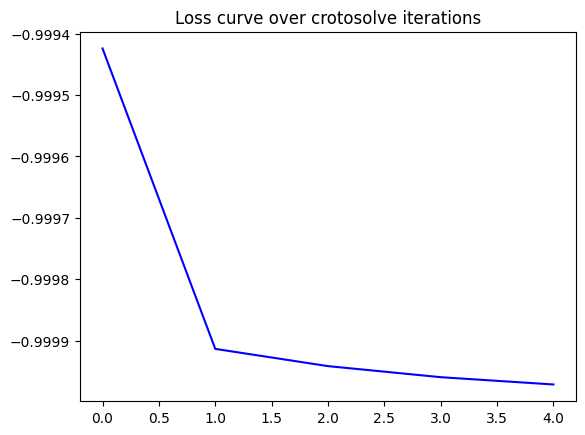

In [11]:

fig, ax = plt.subplots()
ax.plot(range(len(iterations_dataset)), iterations_dataset, 'b')
ax.set_title("Loss curve over crotosolve iterations")

Text(0.5, 1.0, 'Loss curve over circuit evaluations')

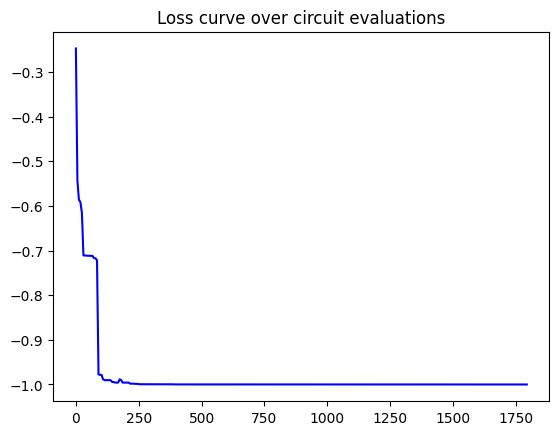

In [12]:

fig, ax = plt.subplots()
# multiply num of updates by 6 to get number of evaluations
ax.plot(6 * np.array(range(len(updates_dataset))), updates_dataset, 'b')
ax.set_title("Loss curve over circuit evaluations")